<a href="https://colab.research.google.com/github/TalesMiguel/RNA/blob/main/trabalho3_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Redes Neurais Artificiais - Trabalho 3: Autoencoders Variacionais (VAE)**

## Feito por:
Camilo Maia Pires - 140473
Tales Miguel Machado Pereira - 140247

## **Introdução**


### Autoencoders Variacionais (VAE)

Autoencoders Variacionais (VAEs) são modelos generativos que combinam redes neurais com inferência variacional para aprender representações latentes de dados. Eles são compostos por duas partes principais: o **encoder**, que mapeia os dados de entrada para um espaço latente, e o **decoder**, que reconstrói os dados a partir desse resultado. A principal diferença entre VAEs e autoencoders tradicionais é que VAEs aprendem uma distribuição de probabilidade no espaço latente estruturado e contínuo.

<br>

### Datasets Utilizados

Para este trabalho, foram selecionados dois datasets rotulados:

1. **Digits Dataset**: Um conjunto de dados que contém imagens de dígitos manuscritos (0 a 9). Cada imagem é representada por uma matriz 8x8 de pixels, resultando em 64 features.

2. **Iris Dataset**: Um conjunto de dados que contém 150 amostras de flores Iris, com 4 features cada (comprimento e largura das sépalas e pétalas) e 3 classes (Setosa, Versicolour e Virginica).

<br>

### Objetivo

O objetivo deste trabalho é treinar modelos VAEs nesses datasets, explorar o espaço latente gerado e analisar a formação de clusters e a separação dos rótulos nesse espaço. Além disso, será avaliado quanto da variância dos dados é capturada pela projeção do espaço latente em 2D usando PCA.

Adicionalmente, tentaremos enviesar a formação do espaço latente com os exemplos previamente rotulados.

<br>


---



## Implementação

### Importação de Bibliotecas



In [52]:
!pip install keras # Corrigindo warning (?) de import do keras

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, losses
from tensorflow.keras import backend as K

### Carregamento dos Datasets

In [59]:
# Digits Dataset
digits = datasets.load_digits()
X_digits = digits.data      # Features
y_digits = digits.target    # Rótulos

# Iris Dataset
iris = datasets.load_iris()
X_iris = iris.data          # Features
y_iris = iris.target        # Rótulos

### Pré-processamento dos Dados

Antes de treinar o VAE, precisamos normalizar os dados para garantir que todas suas features estejam na mesma escala.

In [60]:
X_digits_scaled = StandardScaler().fit_transform(X_digits)
X_iris_scaled = StandardScaler().fit_transform(X_iris)

### Construção do Modelo VAE

A seguir, definimos a arquitetura do VAE. O encoder mapeia os dados de entrada para o espaço latente, enquanto o decoder tenta reconstruir os dados a partir desse espaço.

In [61]:
def create_vae(input_dim, latent_dim):
    """
    Cria um modelo VAE genérico.

    Args:
        input_dim: Dimensão da entrada.
        latent_dim: Dimensão do espaço latente.

        Retorna um modelo VAE compilado
    """

    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    encoder = models.Model(inputs, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(decoder_input)
    outputs = layers.Dense(input_dim, activation='sigmoid')(x)
    decoder = models.Model(decoder_input, outputs, name="decoder")

    # Layers pro Keras não chorar
    class KLLossLayer(layers.Layer):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def call(self, inputs):
            z_mean, z_log_var = inputs
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
            self.add_loss(tf.reduce_mean(kl_loss))
            return z_mean  # Retorna apenas z_mean

    class VAELossLayer(layers.Layer):
        def __init__(self, original_dim, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.original_dim = original_dim

        def call(self, inputs):
            inputs, vae_outputs = inputs
            reconstruction_loss = tf.keras.losses.mse(inputs, vae_outputs)
            self.add_loss(tf.reduce_mean(reconstruction_loss) / self.original_dim)
            return vae_outputs

    # Modelo VAE
    z_mean = KLLossLayer()([z_mean, z_log_var])
    vae_outputs = decoder(z_mean)
    vae_outputs = VAELossLayer(input_dim)([inputs, vae_outputs])

    vae = models.Model(inputs, vae_outputs, name="vae")
    vae.compile(optimizer='adam', loss=lambda y_true, y_pred: 0.0) # Loss function dummy pro keras não chorar pt. 2

    return vae, encoder


### Treinamento do VAE

Treinamos o VAE no Digits Dataset e no Iris Dataset.


In [62]:
# Parâmetros
latent_dim = 2              # dimensao latente
epochs = 50                 # n de épocas
batch_size = 32             # tamanho do pacote
validation_split = 0.2      # validacao cruzada

# Criar e treinar para Digits Dataset
input_dim_digits = X_digits_scaled.shape[1]
vae_digits, encoder_digits = create_vae(input_dim_digits, latent_dim)
vae_digits.fit(X_digits_scaled, X_digits_scaled, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

# Criar e treinar para Iris Dataset
input_dim_iris = X_iris_scaled.shape[1]
vae_iris, encoder_iris = create_vae(input_dim_iris, latent_dim)
vae_iris.fit(X_iris_scaled, X_iris_scaled, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.6139 - val_loss: 0.1780
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1811 - val_loss: 0.1189
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0933 - val_loss: 0.0977
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0846 - val_loss: 0.0857
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0640 - val_loss: 0.0787
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0551 - val_loss: 0.0714
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0492 - val_loss: 0.0670
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0440 - val_loss: 0.0631
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0423 - val_loss: 0.0599
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0378 - val_loss: 0.0568
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0385 - val_loss: 0.0543
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0350 - val_lo

### Exploração do Espaço Latente

Após o treinamento, exploramos o espaço latente gerado pelo VAE. Para isso, projetamos o espaço latente em 2D usando PCA e visualizamos a formação de clusters.


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Variância explicada pelas duas componentes principais: 1.00


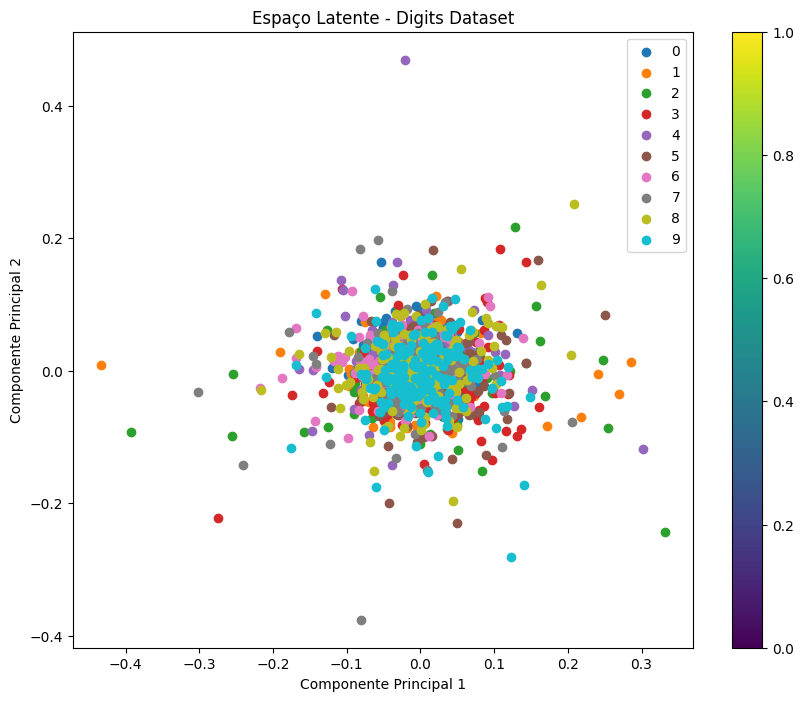

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Variância explicada pelas duas componentes principais: 1.00


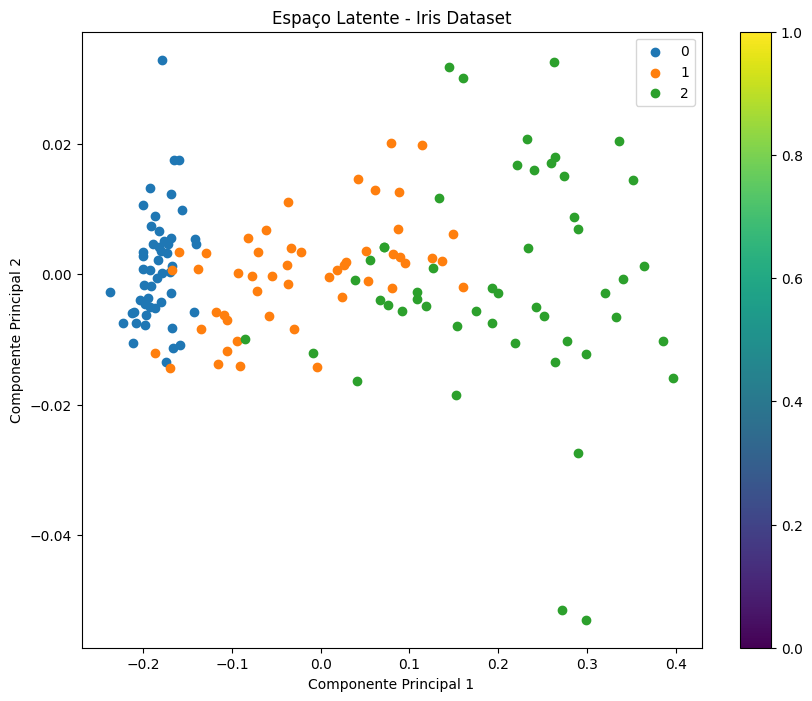

In [63]:
def plot_latent_space(encoder, X, y, title, class_names=None):
    """
    Projeta o espaço latente em 2D usando PCA

    Args:
        encoder: O encoder treinado do VAE.
        X: dados de entrada
        y: rótulos dos dados.
        title: título do gráfico
        class_names: lista de nomes das classes
    """

    z_mean, _, _ = encoder.predict(X)
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_mean)
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Variância explicada pelas duas componentes principais: {explained_variance_ratio.sum():.2f}")

    plt.figure(figsize=(10, 8))

    # um scatter plot para cada classe
    for i in np.unique(y):
        plt.scatter(z_pca[y == i, 0], z_pca[y == i, 1], label=class_names[i] if class_names else str(i))

    plt.colorbar()
    plt.title(title)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()
    plt.show()

# Plot para o Digits Dataset
plot_latent_space(encoder_digits, X_digits_scaled, y_digits, 'Espaço Latente - Digits Dataset')

# Plot para o Iris Dataset
plot_latent_space(encoder_iris, X_iris_scaled, y_iris, 'Espaço Latente - Iris Dataset')

### Análise dos Resultados

#### 1. **Formação de Clusters**:
Digits Dataset: Há uma formação de clusters fraca, agrupando todos os resultados. Os pontos estão concentrados em uma região central, com alguma sobreposição entre as diferentes classes (diferentes dígitos). É possível observar algumas áreas onde certas cores (dígitos) são mais prevalentes, sugerindo a existência de clusters, mas eles não são bem definidos ou separados, tampouco possuem volume considerável de dados. Isso possivelmente gera um ângulo para plotagem de um gráfico com mais dimensões.

Iris Dataset: Há uma formação de clusters visualmente clara. A classe Setosa (cor azul) está bem separada das outras duas classes. As classes Versicolor (cor laranja) e Virginica (cor verde) apresentam alguma sobreposição, mas ainda é possível distinguir clusters distintos.

<br>

#### 2. **Separação dos Rótulos**:
A separação dos rótulos no espaço latente é evidente, especialmente no Iris Dataset, onde as três espécies de flores são bem separadas. No Digits Dataset, alguns dígitos se sobrepõem, o que pode ser devido à similaridade entre eles (por exemplo, os dígitos 1 e 7, ou 0 e 8).

<br>

#### 3. **Variância Capturada**:

A variância foi de 1 para ambos os casos. Isso significa que a projeção PCA em 2D capturou toda a variância dos dados no espaço latente. Isso pode ter alguns significados:

* O VAE pode ter aprendido um espaço latente que é intrinsecamente bidimensional. Isso significa que todas as informações relevantes para a reconstrução dos dados estão contidas em apenas duas dimensões.

Ou ainda

* É possível que a escolha do *latent_dim*=2 tenha sido muito restritiva, forçando a compressão em apenas 2 dimensões. Isso pode ter limitado a capacidade do modelo de aprender padrões mais complexos.

<br>

### Conclusão

Neste trabalho, treinamos modelos VAEs em dois datasets diferentes e exploramos o espaço latente gerado. Observamos a formação de clusters e a separação dos rótulos no espaço latente, além de discutirmos o valor da variância capturada pela projeção PCA. Os resultados foram visualmente claros pro dataset Iris, e deixaram espaço para mais trabalho pro dataset Digits.
